In [1]:
%run ../scripts/notebook_settings_lean.py
import tskit

In [4]:
ts = tskit.load("../results/All_Samples_relate/chromhapX.trees")

In [ ]:
# Version which counts number of samples, and notes both the first coalescence and when 50 % has coalesced.
def coalescence_ordering(tree, IDs, sample_counts):
    df_list = []
    for i in IDs:
        pop_list = []
        gen_list = []
        coal_counts = {}
        for p in sample_counts.index:
            coal_counts[p] = 0
        current_node = i
        while tree.depth(current_node) > 0:
            # Find parent node
            parent_node = tree.parent(current_node)
            # Determine children, and then pick alternate
            # cannot find a method for this, so I use an explicit if/else
            children = tree.children(parent_node)
            if current_node == children[0]:
                alt_node = children[1]
            else:
                alt_node = children[0]
            # Determine which populations are present under the alternate node
            alt_samples = pd.Series([x for x in tree.samples(alt_node)])
            alt_sample_counts = alt_samples.map(i_mapping).value_counts()
            for p in alt_sample_counts.index:
                coal_counts[p] += alt_sample_counts[p]
            # If pop is not already added to list, add pop and note coal time
            for p in alt_sample_counts.index:
                if p  not in pop_list and coal_counts[p] > sample_counts[p]/2:
                    pop_list.append(p)
                    gen_list.append(tree.time(current_node))
            current_node = parent_node
        d = {"ID": i, "sites": tree.num_sites, "span": tree.span, "start": tree.interval[0]}
        for i in range(len(pop_list)):
            d["coal_{}".format(i)] = pop_list[i]
        for i in range(len(gen_list)):
            d["coal_date_{}".format(i)] = gen_list[i]
        df_list.append(pd.DataFrame(d, index=[i]))
    return pd.concat(df_list)

Trying a couple of things shown in the tutorial (https://tskit.dev/tutorials/getting_started.html )

In [ ]:
ts_subset = ts.keep_intervals([[10000000, 11000000]]) #([[67000000, 69000000]]) #([[67000000, 72000000]])

In [ ]:
ts_subset

In [ ]:
# Setup based on poplabels
poplabels = pd.read_csv("../data/pops/all_females_8cluster.sample", sep=" ",
                        names=["ID", "POP", "GROUP", "SEX"], header=0)

i_mapping = {}
for i, row in poplabels.iterrows():
    i_mapping[i*2] = row.GROUP
    i_mapping[i*2+1] = row.GROUP
poplabel_counts = poplabels["GROUP"].value_counts().to_dict()
highest_ID = poplabels.index.max()*2+1

In [ ]:
poplabels.POP.value_counts()

In [ ]:
c = 0
ID_list = list(i_mapping.keys())
sample_counts = poplabels["GROUP"].value_counts()*2
df_list = []
for tree in ts_subset.trees():
    df = coalescence_ordering(tree, ID_list, sample_counts)
    if c % 1000 == 0:
        print(c)
    c += 1
    df_list.append(df)
test_df = pd.concat(df_list)

In [ ]:
test_df

In [ ]:
g = sns.histplot(data=test_df, x="sites")
g.set(xlim=(0,30))

In [ ]:
first_coal_l = []
ID_l = []
for ID in test_df.ID.unique():
    ID_df = test_df.loc[(test_df.ID == ID) & (test_df.coal_date_0 != test_df.coal_date_1)]
    first_coal_l.append(ID_df.coal_0.value_counts().index[0])
    ID_l.append(ID)

In [ ]:
poplabels

In [ ]:
check_df = pd.DataFrame({"first_coal": first_coal_l, "PDGP_ID": ID_l, "POP": pd.Series(ID_l).map(i_mapping)})

In [ ]:
for c in check_df.POP.unique():
    sub_df = check_df.loc[check_df.POP == c]
    print(c)
    print(sub_df["first_coal"].value_counts())

Doing the check with the full chromosome, which I thought had been calculated incorrectly. It was calculated incorrectly in regards to index IDs, which I have fixed now.

In [2]:
# Setup based on poplabels
poplabels = pd.read_csv("../data/pops/all_females_8cluster.sample", sep=" ",
                        names=["ID", "POP", "GROUP", "SEX"], header=0)

i_mapping = {}
for i, row in poplabels.iterrows():
    i_mapping[i*2] = row.GROUP
    i_mapping[i*2+1] = row.GROUP
poplabel_counts = poplabels["GROUP"].value_counts().to_dict()
highest_ID = poplabels.index.max()*2+1

In [3]:
df_l = []
for ID in poplabels.ID:
    df = (pd.read_csv("../steps/relate_coal_ordering/{}.txt".format(ID)))
    df["PDGP_ID"] = ID
    df_l.append(df)
coal_df = pd.concat(df_l)

In [4]:
ID_list = poplabels.ID
ID_t1 = poplabels.loc[poplabels.ID == "PD_0792"].index.values[0]*2
ID_t1

194

In [5]:
df_l[95]

,ID,sites,span,start,coal_0,coal_1,coal_2,coal_3,coal_4,coal_5,...,coal_7,coal_date_0,coal_date_1,coal_date_2,coal_date_3,coal_date_4,coal_date_5,coal_date_6,coal_date_7,PDGP_ID
0,190,5,71983.0,0.0,Tanzanian Olive,Eastern Yellow,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,41.222271,41.222271,41.222271,41.222271,41.222271,26066.427734,26066.427734,26066.427734,PD_0790
1,191,5,71983.0,0.0,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Western Yellow,Hamadryas,Kindae,...,Chacma,94.599716,94.599716,94.599716,94.599716,2329.230225,26066.427734,26066.427734,26066.427734,PD_0790
2,190,33,1242.0,71983.0,Tanzanian Olive,Eastern Yellow,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,64.650093,64.650093,64.650093,64.650093,64.650093,19285.058594,19285.058594,19285.058594,PD_0790
3,191,33,1242.0,71983.0,Tanzanian Olive,Eastern Yellow,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,144.137375,144.137375,144.137375,144.137375,144.137375,19285.058594,19285.058594,19285.058594,PD_0790
4,190,3,49.0,73225.0,Eastern Yellow,Hamadryas,Tanzanian Olive,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1371.026855,1993.067749,2393.278320,2393.278320,2393.278320,8291.375977,8291.375977,9792.259766,PD_0790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239461,191,13,1286.0,143658178.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,350.532410,12273.036133,25803.960938,25803.960938,25803.960938,25803.960938,25803.960938,25803.960938,PD_0790
239462,190,19,2051.0,143659464.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,1405.409546,11107.997070,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,PD_0790
239463,191,19,2051.0,143659464.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,524.869690,11107.997070,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,PD_0790
239464,190,22,11266.0,143661515.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,739.241028,3310.065430,12417.181641,12417.181641,12417.181641,12417.181641,12417.181641,12417.181641,PD_0790


In [6]:
coal_df

,ID,sites,span,start,coal_0,coal_1,coal_2,coal_3,coal_4,coal_5,...,coal_7,coal_date_0,coal_date_1,coal_date_2,coal_date_3,coal_date_4,coal_date_5,coal_date_6,coal_date_7,PDGP_ID
0,0,5,71983.0,0.0,Eastern Yellow,Tanzanian Olive,Western Yellow,Ethiopian Olive,Hamadryas,Kindae,...,Chacma,1236.112305,1633.062744,1633.062744,1988.366699,2329.230225,26066.427734,26066.427734,26066.427734,Sci_16066
1,1,5,71983.0,0.0,Eastern Yellow,Tanzanian Olive,Western Yellow,Ethiopian Olive,Hamadryas,Kindae,...,Chacma,1236.112305,1633.062744,1633.062744,1988.366699,2329.230225,26066.427734,26066.427734,26066.427734,Sci_16066
2,0,33,1242.0,71983.0,Eastern Yellow,Tanzanian Olive,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1344.754639,2068.774658,2068.774658,2068.774658,2068.774658,19285.058594,19285.058594,19285.058594,Sci_16066
3,1,33,1242.0,71983.0,Eastern Yellow,Tanzanian Olive,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1344.754639,2068.774658,2068.774658,2068.774658,2068.774658,19285.058594,19285.058594,19285.058594,Sci_16066
4,0,3,49.0,73225.0,Eastern Yellow,Hamadryas,Tanzanian Olive,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1371.026855,1993.067749,2393.278320,2393.278320,2393.278320,8291.375977,8291.375977,9792.259766,Sci_16066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239461,195,13,1286.0,143658178.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,350.532410,12273.036133,25803.960938,25803.960938,25803.960938,25803.960938,25803.960938,25803.960938,PD_0792
239462,194,19,2051.0,143659464.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,524.869690,11107.997070,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,PD_0792
239463,195,19,2051.0,143659464.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,524.869690,11107.997070,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,27364.220703,PD_0792
239464,194,22,11266.0,143661515.0,Kindae,Western Yellow,Tanzanian Olive,Eastern Yellow,Ethiopian Olive,Hamadryas,...,Chacma,311.643585,3310.065430,12417.181641,12417.181641,12417.181641,12417.181641,12417.181641,12417.181641,PD_0792


Percentage of first coals which are order informative (only coals with that group)

In [10]:
len(coal_df.loc[(coal_df.PDGP_ID == ID) & (coal_df.coal_date_0 != coal_df.coal_date_1)])/len(coal_df.loc[(coal_df.PDGP_ID == ID)])

0.681954849540227

In [11]:
len(coal_df.PDGP_ID.unique())

98

In [12]:
first_coal_l = []
ID_l = []
for ID in coal_df.PDGP_ID.unique():
    print(ID)
    ID_df = coal_df.loc[(coal_df.PDGP_ID == ID) & (coal_df.coal_date_0 != coal_df.coal_date_1)]
    first_coal_l.append(ID_df.coal_0.value_counts().index[0])
    ID_l.append(ID)
first_coal_df = pd.DataFrame({"first_coal": first_coal_l, "PDGP_ID": ID_l,
                              "POP": pd.Series(ID_l).map(dict(zip(poplabels.ID, poplabels.POP)))})

Sci_16066
Sci_16098
Sci_34449
Sci_34474
Sci_97074
PD_0199
PD_0200
PD_0203
PD_0205
PD_0206
PD_0208
PD_0209
PD_0210
PD_0211
PD_0212
PD_0213
PD_0214
PD_0216
PD_0219
PD_0221
PD_0222
PD_0224
PD_0225
PD_0226
PD_0232
PD_0237
PD_0238
PD_0239
PD_0240
PD_0241
PD_0243
PD_0244
PD_0265
PD_0270
PD_0271
PD_0272
PD_0390
PD_0391
PD_0392
PD_0393
PD_0394
PD_0492
PD_0495
PD_0499
PD_0500
PD_0501
PD_0503
PD_0506
PD_0507
PD_0509
PD_0641
PD_0649
PD_0651
PD_0652
PD_0653
PD_0659
PD_0662
PD_0674
PD_0675
PD_0676
PD_0677
PD_0678
PD_0680
PD_0682
PD_0683
PD_0685
PD_0686
PD_0693
PD_0694
PD_0695
PD_0698
PD_0700
PD_0701
PD_0708
PD_0710
PD_0721
PD_0724
PD_0726
PD_0730
PD_0736
PD_0737
PD_0738
PD_0744
PD_0745
PD_0754
PD_0760
PD_0765
PD_0769
PD_0770
PD_0772
PD_0773
PD_0774
PD_0781
PD_0788
PD_0789
PD_0790
PD_0791
PD_0792


In [13]:
first_coal_df = pd.DataFrame({"first_coal": first_coal_l, "PDGP_ID": ID_l,
                              "POP": pd.Series(ID_l).map(dict(zip(poplabels.ID, poplabels.POP)))})

In [14]:
first_coal_df

,first_coal,PDGP_ID,POP
0,Eastern Yellow,Sci_16066,Eastern_Yellow
1,Eastern Yellow,Sci_16098,Eastern_Yellow
2,Kindae,Sci_34449,Kindae
3,Kindae,Sci_34474,Kindae
4,Hamadryas,Sci_97074,Hamadryas
...,...,...,...
93,Kindae,PD_0788,Kindae
94,Kindae,PD_0789,Kindae
95,Kindae,PD_0790,Kindae
96,Kindae,PD_0791,Kindae


In [15]:
for c in first_coal_df.POP.unique():
    sub_df = first_coal_df.loc[first_coal_df.POP == c]
    print(c)
    print(sub_df["first_coal"].value_counts())

Eastern_Yellow
first_coal
Eastern Yellow    21
Name: count, dtype: int64
Kindae
first_coal
Kindae    9
Name: count, dtype: int64
Hamadryas
first_coal
Hamadryas    6
Name: count, dtype: int64
Tanzanian_Olive
first_coal
Tanzanian Olive    43
Name: count, dtype: int64
Western_Yellow
first_coal
Kindae    3
Name: count, dtype: int64
Papio
first_coal
Papio    5
Name: count, dtype: int64
Chacma
first_coal
Chacma    3
Name: count, dtype: int64
Ethiopian_Olive
first_coal
Ethiopian Olive    8
Name: count, dtype: int64


In [16]:
poplabels.POP.value_counts()

POP
Tanzanian_Olive    43
Eastern_Yellow     21
Kindae              9
Ethiopian_Olive     8
Hamadryas           6
Papio               5
Western_Yellow      3
Chacma              3
Name: count, dtype: int64

Checking coal times and spans of trees

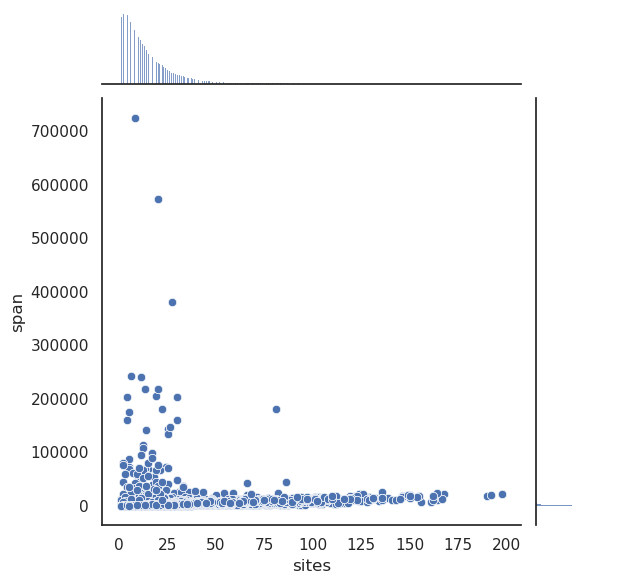

In [17]:
tree_stats_df = coal_df.loc[(coal_df.PDGP_ID == "Sci_16098")]
sns.jointplot(data=tree_stats_df, x="sites", y="span")

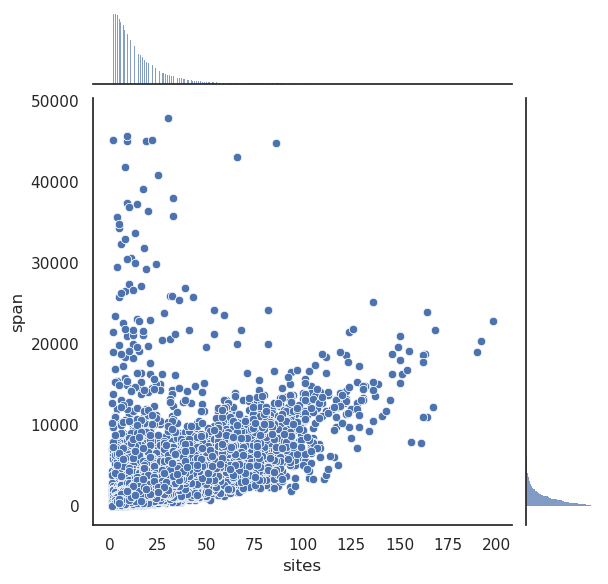

In [18]:
tree_stats_df = coal_df.loc[(coal_df.PDGP_ID == "Sci_16098") & (coal_df.span < 50000)]
sns.jointplot(data=tree_stats_df, x="sites", y="span")

In [19]:
eastern_ids = poplabels.loc[poplabels["POP"] == "Eastern Yellow"].ID

In [20]:
eastern_ids[5:6]

Series([], Name: ID, dtype: object)

In [21]:
eastern_yellow_coals = coal_df.loc[(coal_df.PDGP_ID == "PD_0224") & (coal_df.sites > 9)]# coal_df.loc[(coal_df.PDGP_ID.isin(eastern_ids)) & (coal_df.sites > 9)]
eastern_yellow_coals

,ID,sites,span,start,coal_0,coal_1,coal_2,coal_3,coal_4,coal_5,...,coal_7,coal_date_0,coal_date_1,coal_date_2,coal_date_3,coal_date_4,coal_date_5,coal_date_6,coal_date_7,PDGP_ID
2,42,33,1242.0,71983.0,Eastern Yellow,Tanzanian Olive,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1344.754639,2068.774658,2068.774658,2068.774658,2068.774658,19285.058594,19285.058594,19285.058594,PD_0224
3,43,33,1242.0,71983.0,Eastern Yellow,Tanzanian Olive,Hamadryas,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,1344.754639,2068.774658,2068.774658,2068.774658,2068.774658,19285.058594,19285.058594,19285.058594,PD_0224
6,42,12,280.0,73274.0,Eastern Yellow,Hamadryas,Tanzanian Olive,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,2432.219971,3523.781982,4038.057129,4038.057129,4038.057129,10572.315430,10572.315430,11394.324219,PD_0224
7,43,12,280.0,73274.0,Eastern Yellow,Hamadryas,Tanzanian Olive,Ethiopian Olive,Western Yellow,Kindae,...,Chacma,2432.219971,3523.781982,4038.057129,4038.057129,4038.057129,10572.315430,10572.315430,11394.324219,PD_0224
12,42,12,216.0,73805.0,Eastern Yellow,Kindae,Tanzanian Olive,Hamadryas,Western Yellow,Ethiopian Olive,...,Chacma,1284.051636,1727.403076,2458.157959,2458.157959,2458.157959,3504.058105,5131.117188,9801.495117,PD_0224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239461,43,13,1286.0,143658178.0,Eastern Yellow,Tanzanian Olive,Ethiopian Olive,Hamadryas,Papio,Chacma,...,Western Yellow,1249.188721,3794.046631,3794.046631,3794.046631,3794.046631,3794.046631,27700.523438,27700.523438,PD_0224
239462,42,19,2051.0,143659464.0,Eastern Yellow,Chacma,Tanzanian Olive,Ethiopian Olive,Papio,Hamadryas,...,Western Yellow,1439.507935,2223.068604,6855.901855,6855.901855,6855.901855,6855.901855,13374.691406,13374.691406,PD_0224
239463,43,19,2051.0,143659464.0,Eastern Yellow,Chacma,Tanzanian Olive,Ethiopian Olive,Papio,Hamadryas,...,Western Yellow,1083.280518,2223.068604,6855.901855,6855.901855,6855.901855,6855.901855,13374.691406,13374.691406,PD_0224
239464,42,22,11266.0,143661515.0,Eastern Yellow,Hamadryas,Chacma,Tanzanian Olive,Ethiopian Olive,Papio,...,Western Yellow,760.987549,1987.681152,5675.307129,8542.875977,8542.875977,8542.875977,20771.869141,20771.869141,PD_0224


In [26]:
coal_type_l, coal_date_l, start_pos, haplo_l  = [], [], [], []
for coal_type in ["Kindae", "Hamadryas", "Eastern Yellow"]:
    for coal in range(0, 8):
        print(coal)
        coal_timings = eastern_yellow_coals.loc[eastern_yellow_coals["coal_{}".format(coal)] == coal_type]
        coal_type_l.extend(list(coal_timings["coal_{}".format(coal)]))
        coal_date_l.extend(list(coal_timings["coal_date_{}".format(coal)]))
        start_pos.extend(list(coal_timings.start))
        haplo_l.extend(list(coal_timings.ID))

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


In [23]:
sub_coal_df = pd.DataFrame({"coal_type": coal_type_l, "coal_date": coal_date_l, "start": start_pos, "haplotype": haplo_l})

[(-10.0, 70000.0)]

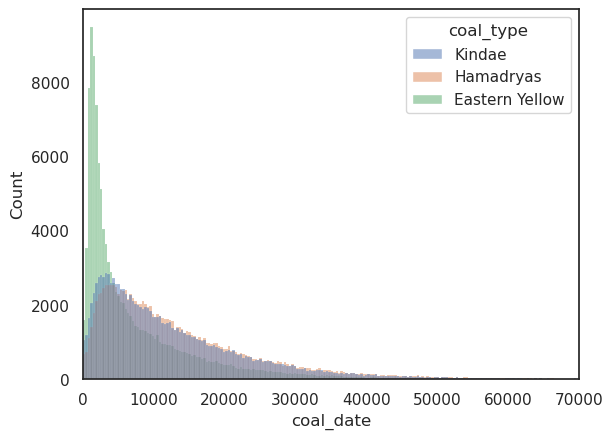

In [24]:
g = sns.histplot(sub_coal_df, x="coal_date", hue="coal_type")
g.set(xlim= (-10, 70000))

[(-10.0, 70000.0)]

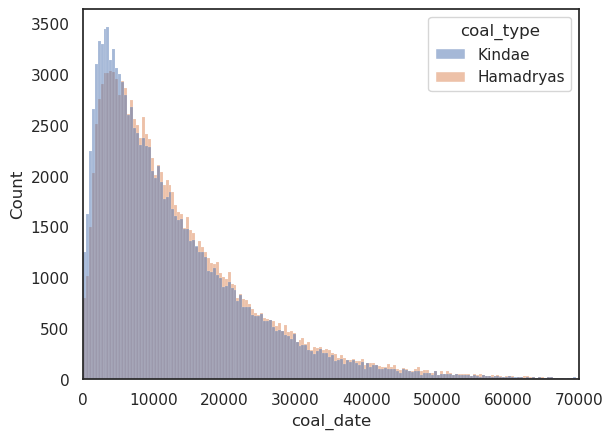

In [25]:
g = sns.histplot(sub_coal_df.loc[sub_coal_df.coal_type.isin(["Kindae", "Hamadryas"])],
                 x="coal_date", hue="coal_type")
g.set(xlim= (-10, 70000))

In [27]:
hamadryas_coal = sub_coal_df.loc[sub_coal_df.coal_type == "Hamadryas"]

In [28]:
len(hamadryas_coal.loc[hamadryas_coal.coal_date > 10000])/len(hamadryas_coal)

0.5176153521446895

In [29]:
hamadryas_coal.coal_date.mean()

13641.463903496211

In [30]:
sub_coal_df

,coal_type,coal_date,start,haplotype
0,Kindae,2447.870605,75803.0,42
1,Kindae,2447.870605,75803.0,43
2,Kindae,1911.864014,83501.0,42
3,Kindae,1911.864014,83501.0,43
4,Kindae,3697.953369,94256.0,42
...,...,...,...,...
369559,Eastern Yellow,24230.320312,141875302.0,42
369560,Eastern Yellow,12558.096680,141903330.0,42
369561,Eastern Yellow,15287.358398,141906025.0,42
369562,Eastern Yellow,23256.238281,142602730.0,42


In [31]:
coal_type_l, coal_date_l, start_pos, haplo_l  = [], [], [], []
df_l = []
for coal_type in ["Kindae", "Hamadryas"]:
    for coal in range(0, 8):
        print(coal)
        coal_timings = eastern_yellow_coals.loc[eastern_yellow_coals["coal_{}".format(coal)] == coal_type]
        coal_type_l.extend(list(coal_timings["coal_{}".format(coal)]))
        coal_date_l.extend(list(coal_timings["coal_date_{}".format(coal)]))
        start_pos.extend(list(coal_timings.start))
        haplo_l.extend(list(coal_timings.ID))
    df_l.append(pd.DataFrame({"coal_date_{}".format(coal_type): coal_date_l,
                                "start": start_pos, "haplotype": haplo_l}))
coal_comp_df = df_l[0]
for d in df_l[1:]:
    coal_comp_df = coal_comp_df.merge(d, how="left", on=["start", "haplotype"])

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


In [32]:
coal_comp_df

,coal_date_Kindae,start,haplotype,coal_date_Hamadryas
0,2447.870605,75803.0,42,2447.870605
1,2447.870605,75803.0,42,11565.172852
2,2447.870605,75803.0,43,2447.870605
3,2447.870605,75803.0,43,11565.172852
4,1911.864014,83501.0,42,1911.864014
...,...,...,...,...
246371,25597.566406,143649954.0,43,9317.244141
246372,22300.873047,143652272.0,42,22300.873047
246373,22300.873047,143652272.0,42,12906.602539
246374,22300.873047,143652272.0,43,22300.873047


In [33]:
coal_comp_df.loc[coal_comp_df.coal_date_Kindae > coal_comp_df.coal_date_Hamadryas]

,coal_date_Kindae,start,haplotype,coal_date_Hamadryas
26787,7719.367676,591699.0,42,5914.112305
26789,11706.638672,594073.0,42,3155.060303
26891,2376.324219,1222188.0,42,971.551331
27023,5913.278320,1547909.0,42,3794.030029
27153,3430.208008,1744046.0,42,2732.729980
...,...,...,...,...
246367,33553.636719,143590363.0,43,17643.457031
246369,25597.566406,143649954.0,42,9317.244141
246371,25597.566406,143649954.0,43,9317.244141
246373,22300.873047,143652272.0,42,12906.602539


In [34]:
coal_comp_df.loc[coal_comp_df.coal_date_Kindae < coal_comp_df.coal_date_Hamadryas]

,coal_date_Kindae,start,haplotype,coal_date_Hamadryas
1,2447.870605,75803.0,42,11565.172852
3,2447.870605,75803.0,43,11565.172852
5,1911.864014,83501.0,42,19073.660156
7,1911.864014,83501.0,43,19073.660156
9,3697.953369,94256.0,42,6620.400879
...,...,...,...,...
233319,7669.697754,141674134.0,43,14312.352539
233397,16239.457031,142550857.0,42,22263.658203
233399,16239.457031,142550857.0,43,22263.658203
233409,21357.306641,143119984.0,42,30566.353516


In [35]:
coal_comp_df.loc[coal_comp_df.coal_date_Kindae == coal_comp_df.coal_date_Hamadryas]

,coal_date_Kindae,start,haplotype,coal_date_Hamadryas
0,2447.870605,75803.0,42,2447.870605
2,2447.870605,75803.0,43,2447.870605
4,1911.864014,83501.0,42,1911.864014
6,1911.864014,83501.0,43,1911.864014
8,3697.953369,94256.0,42,3697.953369
...,...,...,...,...
246366,33553.636719,143590363.0,43,33553.636719
246368,25597.566406,143649954.0,42,25597.566406
246370,25597.566406,143649954.0,43,25597.566406
246372,22300.873047,143652272.0,42,22300.873047


[(-10.0, 70000.0)]

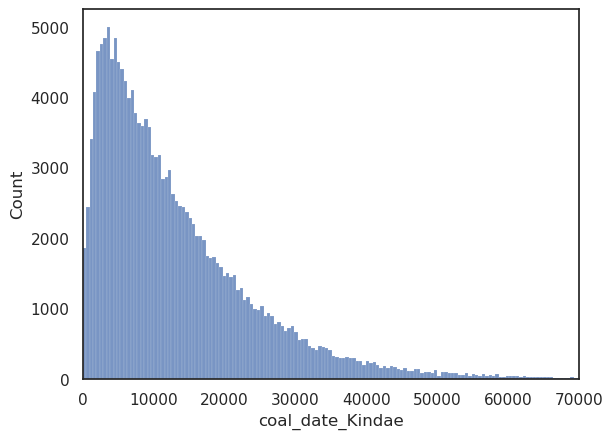

In [36]:
g = sns.histplot(coal_comp_df.loc[coal_comp_df.coal_date_Kindae == coal_comp_df.coal_date_Hamadryas],
                 x="coal_date_Kindae")
g.set(xlim= (-10, 70000))